In [5]:
import numpy as np
import cvxpy as cvx
from scipy import sparse

In [6]:
from imTools import *

In [7]:
# target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (100,100))
# base = readImage('images/BrainT1Slice.png', (100,100))
target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (50,50))
base = readImage('images/BrainT1Slice.png', (50,50))

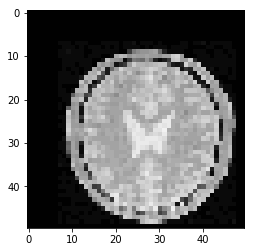

In [8]:
plt.imshow(target)
plt.show()

In [9]:
from Taylor08 import *

In [10]:
px = np.random.random(19)*0.5
py = np.random.random(19)*0.5
p = np.concatenate((px,py), axis=0)

In [11]:
D = gaussianDeformImage(target, 10, 4, px, py)

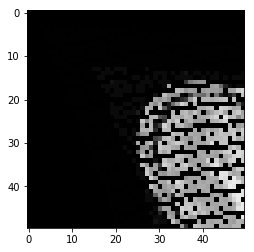

In [12]:
plt.imshow(D)
plt.show()

In [13]:
(dIm, Ax, Ay, Iz, b, Dx, Dy, C) = Taylor08(target, base, 10, px, py)

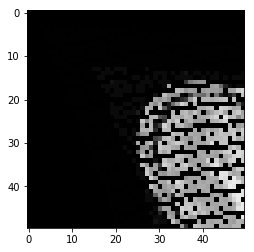

In [14]:
plt.imshow(dIm)
plt.show()

In [15]:
Ax.shape

(52019, 2500)

In [16]:
z = np.ones(Ax.shape[1])
A = (Ax @ C @ px) + (Ay @ C @ py) - Iz@z

In [17]:
s = b - A
d = sparse.diags(s**(-1))
d2 = d**2

In [18]:
D1 = Ax.T @ d2 @ Ax
D2 = Ay.T @ d2 @ Ax
D3 = Ay.T @ d2 @ Ay
D4 = Iz.T @ d2 @ Ax
D5 = Iz.T @ d2 @ Ay
D6 = Iz.T @ d2 @ Iz
# With no lower / upper bounds on Dx, Dy

In [19]:
# Constructs Hp
Hpx = C.T@D1@C
Hpxpy = C.T @ D2 @ C
Hpy = C.T@D3@C

Hp1 = np.concatenate((Hpx, Hpxpy), axis = 1)
Hp2 = np.concatenate((Hpxpy, Hpy), axis = 1)
Hp = np.concatenate((Hp1, Hp2), axis = 0)

In [20]:
# Construct Hz
Hz1 = D4 @ C
Hz2 = D5 @ C

Hz = np.concatenate((Hz1, Hz2), axis = 1)

In [21]:
gz = -1 * Iz.T@s**(-1)
gpx = -1 * C.T@Ax.T@s**(-1)
gpy = -1 * C.T@Ay.T@s**(-1)
gp = np.concatenate((gpx, gpy), axis = 0)

In [22]:
Hp.shape

(38, 38)

In [23]:
def TaylorNewtonStep(Ax, Ay, Iz, b, s, d, d2, p, z):    
    """ 
    *CURRENTLY BROKEN**

    With each iteration we are seeking to minimize 
    t 1.T@z - sum[ log(b - AxCpx - (Ay @ C @ py)  + (Iz @ z)) ]

    """
    # Line Search Parameters:
    alpha = 0.01
    beta = 0.8
    eps = 10
    maxiters = 100
    count = 0
    
    # Convex Approximation & Deformation Parameters
    window = 10
    k = 4 # 16 kernels
    sigma = 10
    
    
    for iter in range(maxiters):
        count += 1
        (Ax, Ay, Iz, b, Dx, Dy, C) = getConstraintCoeffs2(target, base, window, k, sigma, p[:19], p[19:])
        L = Ax.shape[1]
        A = (Ax @ C @ px) + (Ay @ C @ py) - Iz@z

        s = b - A
        print(s)
        d = sparse.diags(s**(-1))
        d2 = d**2
        (Hp, Hz, D6) = getHessians(Ax, Ay, Iz, C, d2)
        
        gpx = -1 * C.T@Ax.T@s**(-1)
        gpy = -1 * C.T@Ay.T@s**(-1)
        gp = np.concatenate((gpx, gpy), axis = 0)
        gz = -1 * Iz.T@s**(-1)
        g = np.concatenate((gp, gz), axis = 0)
#         print(g)
        Dinv = sparse.linalg.inv(D6)
        
        dp = np.linalg.solve(Hp - Hz.T @ Dinv @ Hz, gp - Hz.T @ Dinv @ gz)
#         print(dp)
        dz = sparse.linalg.inv(D6)@(gz - Hz @ dp)
        delta = np.concatenate((dp, dz), axis = 0)
        
        lambdasqr = g.T @ delta #-1*g.T @ delta
#         print(lambdasqr)
        
        if lambdasqr/2 < eps:
            break
            
        # otherwise perform line search:
        t = 1

        while  (t * np.ones(len(dz)).T @ dz - np.sum( np.log( b - (Ax@C@(p + t * dp)[:19]) - (Ay @ C @ (p + t * dp)[19:]) + Iz@(z + dz))) - alpha * t * (gz.T @ dz) > 0):
            t = beta * t
            
        p += t * dp
        z += t * dz
        print(p)
    if count == maxiters:
        print('ERROR: MAXITERS reached.\n')
        p = 0
    
    return p
    

In [ ]:
p1 = np.random.rand(38)
z = z = 50*np.ones(Ax.shape[1])
p = TaylorNewtonStep(Ax, Ay, Iz, b, s, d, d2, p1, z)

In [ ]:
z = 50*np.ones(Ax.shape[1])
t = 1
b - (Ax@C@p[:19]) - (Ay @ C @ p[19:]) + Iz@z

In [ ]:
window = 10
k = 4 # 16 kernels
sigma = 10

(Ax, Ay, Iz, b, Dx, Dy, C) = getConstraintCoeffs2(target, base, window, k, sigma, p[:19], p[19:])